<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/connor_module/Time_Series_Analysis_and_Forecasting/N1_Simulating_Projectile_Motion_with_Drag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Allow for use of widgets in the notebook
try:
    from google.colab import output
    output.enable_custom_widget_manager()
    IN_COLAB = True
except:
    IN_COLAB = False

In [ ]:
%%capture
!pip install ipympl
%matplotlib widget

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import time
import pickle
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Notebook 1: Generating time series data of projectile motion

In this notebook, we will explore projectile motion in some detail.
This topic is often treated in an idealized setting (no air resistance, perfectly spherical object, etc.).
Here, we will try to generate more realistic observations of projectile motion where there are a range of influences including variations in pressure, temperature, wind, and generally drag.
We will even consider imperfections in measurement as would be found in sensor based observations of an object in motion.

The goal of this exercise is to prepare a set of time-series data for many trajectories that we can subsequently analyze using standard time-series analysis tools.

## Projectile motion

From Newton's second law, we know that the acceleration of an object is determined by its mass and the forces acting on it:
$$
\vec{F} = m\vec{a}
\tag{1}
$$
where $\vec{F}$ is the force, $m$ is the mass, and $\vec{a}$ is the acceleration.
For easy of plotting to see our results, we will consider a two dimensional world where $x$ represents the horizontal distance and $y$ represents the vertical height.
Thus, our forces and acceleration have a horizontal and vertical component:
$$
\vec{F} = \begin{bmatrix}F_x \\ F_y\end{bmatrix},\quad \vec{a} = \begin{bmatrix}a_x \\ a_y\end{bmatrix}.
$$

Now, for a projectile which has been propelled from the ground into the air, the only force that is considered in the idealized setting is gravity which only acts in the vertical component:

$$
\vec{F}_g = m\begin{bmatrix}0 \\ g\end{bmatrix}.
$$

Let's begin by writing a program that can simulate the projectile motion under only this force.
To do so, we consider the position ($\vec{p}(t)$), velocity ($\vec{v}(t)$), and accleration ($\vec{a}(t)$) of the projectile, which are all functions of time $t$:

$$
\begin{align}
  \vec{a} &= \frac{d}{d t}\vec{v} = \frac{d^2}{dt^2}p.
\end{align}
$$

From this, we can write Equation 1 for the projectile motion as:

$$
\begin{align}
\vec{a} &= \frac{1}{m}F_g \\
\vec{a} &= \begin{bmatrix}0 \\ g\end{bmatrix}\\
\frac{d^2}{dt^2}\vec{p} &= \begin{bmatrix}0 \\ g\end{bmatrix}\tag{2}
\end{align}
$$

## Numerically solving projectile motion
In order to approximate the solution to Equation 2, we can consider an "initial value problem" for which we know the values of $\vec{p}(t_0)$, $\vec{v}(t_0)$, and $\vec{a}(t_0)$ at a starting time $t_0$.
We can then write Equation 2 as a first order differential equation by splitting it into its component parts:

$$
\begin{align}
\frac{d}{dt}\begin{bmatrix}\frac{d}{dt}p_x \\ \frac{d}{dt}p_y \\ p_x \\ p_y\end{bmatrix}
&= \begin{bmatrix}0 \\ g \\ v_x \\ v_y \end{bmatrix}
\end{align}
$$
or equivalently,
$$
\begin{align}
\frac{d}{dt}\begin{bmatrix}\;\;v_x\;\; \\ v_y \\ p_x \\ p_y\end{bmatrix}
&= \begin{bmatrix}0 \\ g \\ v_x \\ v_y \end{bmatrix}\tag{3}
\end{align}
$$

It may seem strange to write the equations in this form, however, we can now approximate the time derivative $\frac{d}{dt}$ using the limit definition from calculus as:

$$
\frac{d}{dt}v_x(t) = \underset{h\rightarrow 0}{\text{lim}} \frac{v_x(t+h) - v_x(t)}{h} \approx \frac{v_x(t+\Delta t) - v_x(t)}{\Delta t}
$$

when $\Delta t$ is small.
We can then approximate the solution to Equation 3 at time $t_0+\Delta t$ by computing:

$$
\begin{align}
\frac{1}{\Delta t} \left(\begin{bmatrix}\;\;v_x(t_0+\Delta t)\;\; \\ v_y(t_0+\Delta t) \\ p_x(t_0+\Delta t) \\ p_y(t_0+\Delta t)\end{bmatrix}
- \begin{bmatrix}\;\;v_x(t_0)\;\; \\ v_y(t_0) \\ p_x(t_0) \\ p_y(t_0)\end{bmatrix}\right)
&=
\begin{bmatrix}0 \\ g \\ v_x(t_0) \\ v_y(t_0) \end{bmatrix}
\\
\begin{bmatrix}\;\;v_x(t_0+\Delta t)\;\; \\ v_y(t_0+\Delta t) \\ p_x(t_0+\Delta t) \\ p_y(t_0+\Delta t)\end{bmatrix}
&=
 \begin{bmatrix}\;\;v_x(t_0)\;\; \\ v_y(t_0) \\ p_x(t_0) \\ p_y(t_0)\end{bmatrix}
 + \Delta t
 \begin{bmatrix}0 \\ g \\ v_x(t_0) \\ v_y(t_0) \end{bmatrix}\\
\begin{bmatrix}\;\;v_x(t_0+\Delta t)\;\; \\ v_y(t_0+\Delta t) \\ p_x(t_0+\Delta t) \\ p_y(t_0+\Delta t)\end{bmatrix}
&=
 \begin{bmatrix}\;\;v_x(t_0)\;\; \\ v_y(t_0) \\ p_x(t_0) \\ p_y(t_0)\end{bmatrix}
 + \Delta t
 \vec{f}(t_0,v_x,v_y,p_x,p_y)
\end{align}
$$

This is called "Euler's method" for solving initial value problems of ordinary differential equations of the form $\frac{d}{dt}\vec{u} = f(t,\vec{u})$.

Euler's method has several shortcomings. Fortunately, there are great improved methods available in popular Python libraries such as `sympy`.

Let's use the `sympy` function `solve_ivp` (solve initial value problem) to solve this problem:

We'll begin by creating a force function for gravity `f_g` which takes as inputs the time `t` and the velocity and position vector `u` and returns the acceleration and velocity vector
$$
 \begin{bmatrix}0 \\ g \\ v_x(t_0) \\ v_y(t_0) \end{bmatrix}
$$


In [ ]:
# Setup gravity force function f_g(t,u) where u = (v_x, v_y, p_x, p_y)
g = -9.8 # m/s
def f_g(t, u):
    return np.array([0, g, u[0], u[1]])

Next we setup the variables for the problem.
The starting time $t_0$, the max run time $t_1$, the time step spacing `dt`, and the initial conditions $[v_x,v_y,p_x,p_y]$ at time $t_0$.

In [ ]:
# Start at time 0 and go to time 200, collect every Δt = 0.01
t0 = 0
t1 = 200
dt = .1

# Setup initial conditions (velocity (100,100) m/s at position (0,0))
u0 = np.array([100, 100, 0, 0])

Now, our simulation only really matters to us until the projectile hits the ground.
The `scipy` Python library allows for us to put in conditions at which the simulation will terminate.
So, we make a `hit_ground` which returns the height of the projectile.

In [ ]:
# We'd like to end as soon as we hit the ground i.e. when height p_y <= 0
# So make a function that returns our height p_y
def hit_ground(t, u):
    return u[3]
# Now we add some characteristics to the function to make it usable by scipy
hit_ground.terminal = True # Stop simulating when the function crosses 0
hit_ground.direction = -1  # Stop only when crossing from positive to negative

We now use the scipy function `solve_ivp` (solve initial value problem) to simulate the projectile motion from time $t_0$ to $t_1$ collecting position and velocity every `dt` time where our equation looks like $u' = f_g(t, u)$ and we stop if $y$ crosses $0$

In [ ]:
u_solution = solve_ivp(f_g, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

The solution object from `scipy` has a variety of information in it:

In [ ]:
# Did it work? yes = 0,1 or no = -1
print("Success:")
print(u_solution.success)
print("Message:")
print(u_solution.message)
print()

# Times at which solution has been approximated
print("Number of times:")
print(u_solution.t.shape[0])
print("Times (first 5):")
print(u_solution.t[:5])
print()

# Solution values at time points
# (Rows correspond to (v_x,v_y,p_x,p_y) respectively and columns correspond to time points)
print("Shape of solution:")
print(u_solution.y.shape)
print("Solution (first 5):")
print(u_solution.y[:,:5])

Success:
True
Message:
A termination event occurred.

Number of times:
205
Times (first 5):
[0.  0.1 0.2 0.3 0.4]

Shape of solution:
(4, 205)
Solution (first 5):
[[100.    100.    100.    100.    100.   ]
 [100.     99.02   98.04   97.06   96.08 ]
 [  0.     10.     20.     30.     40.   ]
 [  0.      9.951  19.804  29.559  39.216]]


We can also plot the solution:

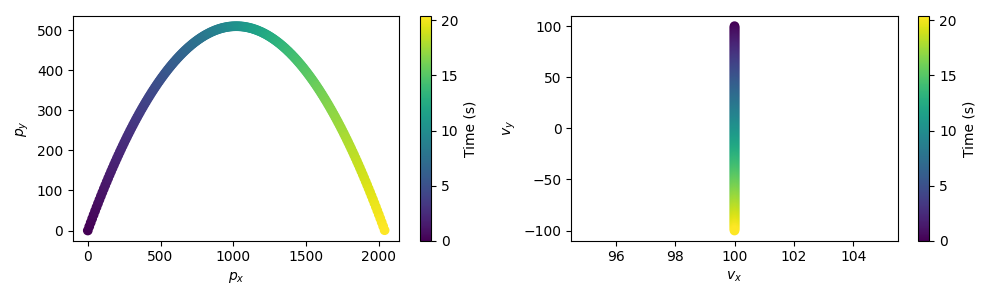

In [ ]:
plt.close('all')
fig = plt.figure(figsize=(10,3))

# Plot position
plt.subplot(1,2,1)
plt.scatter(u_solution.y[2,:],u_solution.y[3,:],c=u_solution.t)
plt.xlabel("$p_x$")
plt.ylabel("$p_y$")
plt.colorbar(label="Time (s)")

# Plot velocity
plt.subplot(1,2,2)
plt.scatter(u_solution.y[0,:],u_solution.y[1,:],c=u_solution.t)
plt.xlabel("$v_x$")
plt.ylabel("$v_y$")
plt.colorbar(label="Time (s)")

plt.tight_layout() # Make sure all labels are visible
plt.show()

As we'd expect, the projectile is intially launched up into the air and is pulled back down to the ground. The velocity is unchanged in the horizontal direction $v_x$ as there are no forces in that direction, while the vertical velocity decreases.

Note that even though we had a maximum time of $t_1 = 200$, we only needed about 20 seconds of simulation before hitting the ground.

----

### Problem 1
Simulate projectile motion with an initial condition of $v = [10, 100]$ and then plot the solution as is shown above.

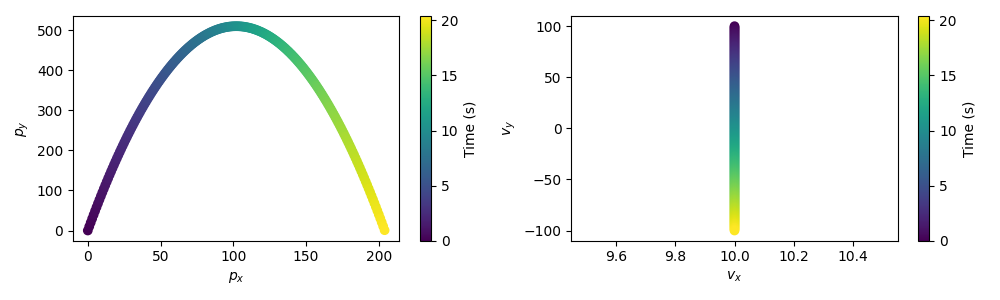

In [ ]:
# Answer to Problem 1

----

## Projectile motion with drag

The most common additional force beyond gravity is to incorporate "drag." This is easiest for me to imagine in the context of water - if you throw a projectile into water, the water will exert a force or "resist" against the projectile, slowing it down.

The equation for the drag force exerted is written:

$$
\vec{F}_d = \frac{1}{2}\rho\vec{v}^2c_dA\tag{4}
$$

where $\rho$ is the density of the air/fluid, $c_d$ is the drag coefficient (based on the projectile shape and material properties), and $A$ is the area of the projectile surface which is exerting force on the air/fluid.

Although this equation initially appears simple, it's components can be very complex.
For example,
1. $\rho$ - the density varies with temperature, pressure, and humidity
1. $c_d$ - the drag coefficient depends on the material properties, the surface area in the direction of movement, and the fluid properties

Though we will not consider the full complexity of this drag, we can consider some cases for projectile motion through the air.
Doing so, we can input Equation 4 into Equation 2 as

$$
\begin{align}
\vec{a} &= \frac{1}{m}(\vec{F}_g + \vec{F}_d) \\
\vec{a} &= \begin{bmatrix}0 \\ g\end{bmatrix} + \frac{\rho c_d A}{2m}\begin{bmatrix}v_x^2 \\ v_y^2\end{bmatrix} \\
\frac{d^2}{dt^2}\vec{p} &= \begin{bmatrix}0 \\ g\end{bmatrix} + \frac{\rho c_d A}{2m}\begin{bmatrix}v_x^2 \\ v_y^2\end{bmatrix}\tag{5}
.\end{align}
$$

This can be written as a first order differential equation as

$$
\begin{align}
\frac{d}{dt}\begin{bmatrix}\;\;v_x\;\; \\ v_y \\ p_x \\ p_y\end{bmatrix}
&= \begin{bmatrix}\frac{\rho c_d A}{2m}v_x^2 \\ g + \frac{\rho c_d A}{2m}v_y^2\\ v_x \\ v_y \end{bmatrix}\tag{6}
.\end{align}
$$

We can now replicate the above simulation with some drag incorporated using Equation 6 (only in the x component).

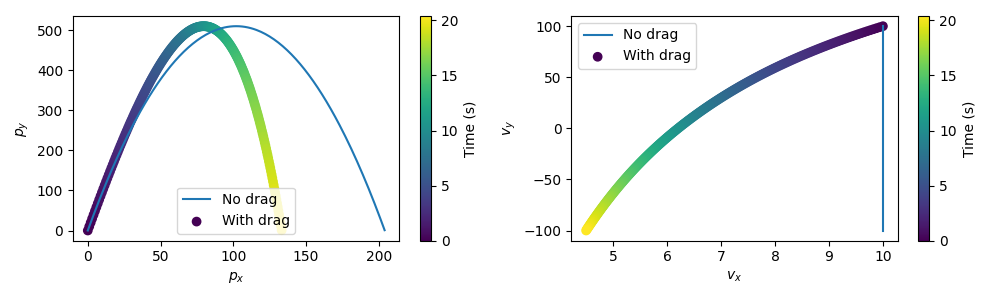

In [ ]:
# Adjust force function to include drag for constant density, area, and drag coefficient
rho = 1.2      # kg/m^3 (standard air density)
c_d = -0.5     # dimensionless (drag coefficient for a rough sphere)
A = 0.2        # m^2 (area of the object face)
m = 10         # kg (mass of the object)

# Drag force (only in x, no drag in y)
def f_with_drag(t,u):
    return np.array(
        [
          0.5 * (rho*c_d*A) * u[0]**2 / m,
          g,
          u[0],
          u[1]
        ]
   )

# Solve with new forcing
u_drag_solution = solve_ivp(f_with_drag, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

# Plot
plt.close('all')
fig = plt.figure(figsize=(10,3))

# Plot position
plt.subplot(1,2,1)
plt.plot(u_solution.y[2,:],u_solution.y[3,:],label="No drag")
plt.scatter(u_drag_solution.y[2,:],u_drag_solution.y[3,:],c=u_drag_solution.t,label="With drag")
plt.xlabel("$p_x$")
plt.ylabel("$p_y$")
plt.legend()
plt.colorbar(label="Time (s)")

# Plot velocity
plt.subplot(1,2,2)
plt.plot(u_solution.y[0,:],u_solution.y[1,:],label="No drag")
plt.scatter(u_drag_solution.y[0,:],u_drag_solution.y[1,:],c=u_drag_solution.t,label="With drag")
plt.xlabel("$v_x$")
plt.ylabel("$v_y$")
plt.legend()
plt.colorbar(label="Time (s)")

plt.tight_layout()
plt.show()

As would be expected, adding drag to the projectile motion significantly hampers the distance it travels. However, it is not immediately apparent how each of the parameters contributes to the final trajectory.

----

### Problem 2
The above demonstration only includes drag in the $x$ component.
Adjust the code to add the y component of the drag force and name the function `f_with_drag` as is shown above.


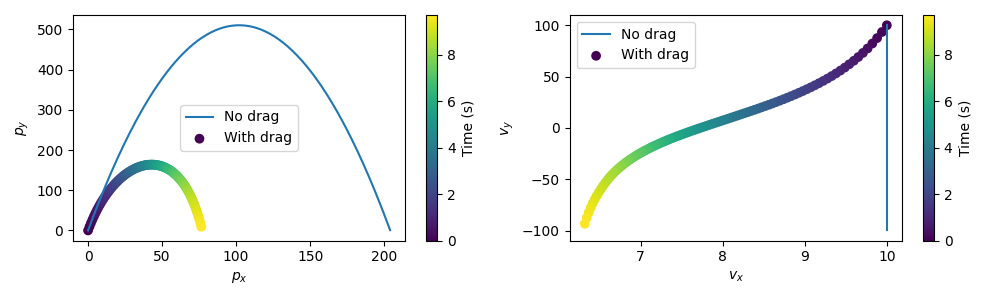

In [ ]:
# Answer to Problem 2

----

## Exploring data with interactive plotting

In order to better understand how each of the parameters contributes to the final trajectory of the projectile, we can do some "interactive" plotting.
This is facilitated by the `pywidgets` Python package.
Though we are exploring the use of this package in the context of a physical simulation, this tool can be used for a range of data exploration or data presentation purposes.

The general idea of these widgets is to make a plot that can change as we adjust some "sliders" or input boxes with the parameter values.
See below for an example of this.

FloatSlider(value=65.0, description='Start angle', max=89.0, min=1.0, step=2.0)

FloatSlider(value=8.0, description='Initial velocity', max=30.0, min=1.0, step=2.0)

FloatSlider(value=1.0, description='Mass', max=10.0, min=1.0, step=0.5)

FloatSlider(value=1.0, description='Drag coefficient', max=2.0)

Button(description='Update plot', style=ButtonStyle())

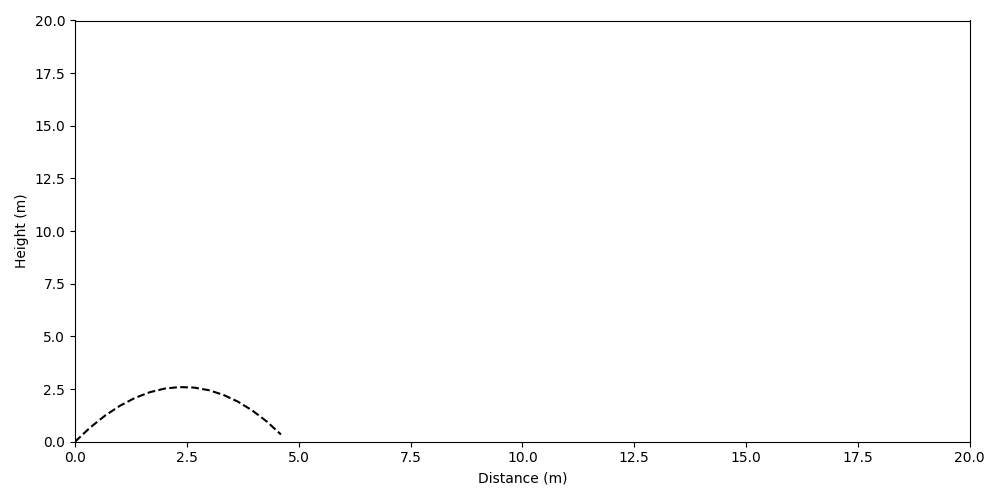

In [ ]:
# Close any previously opened plots
plt.close('all')

#####################################################################################
# Make slider widgets
#####################################################################################
angle    = widgets.FloatSlider(min=1,max=89 ,step=2, description="Start angle",value = 65)
velocity = widgets.FloatSlider(min=1,max=30 ,step=2,description="Initial velocity",value = 8)
mass     = widgets.FloatSlider(min=1,max=10 ,step=.5,description="Mass",value = 1)
drag     = widgets.FloatSlider(min=0,max=2  ,step=.1,description="Drag coefficient",value = 1)

update_plot = widgets.Button(description="Update plot")

# Print widgets
display(angle); display(velocity); display(mass);
display(drag);
display(update_plot)

#####################################################################################
# Initialize plot
#####################################################################################
# Make figure and get the "axis" object (has the plot limits etc.)
fig = plt.figure(figsize=(10,5))
ax = fig.gca()

# Calculate the x and y components of velocity from the given angle
vx = velocity.value*np.cos(angle.value*(np.pi/180))
vy = velocity.value*np.sin(angle.value*(np.pi/180))

# Calculate the trajectory by solving the ode
def f_with_drag2(t,u):
    c_d = -drag.value
    return np.array([0.5*(rho*c_d*A)*u[0]**2/m, g + 0.5*(rho*c_d*A)*u[1]**2/m, u[0], u[1]])

# Solve with new forcing
u_drag_solution2 = solve_ivp(f_with_drag2, (t0,t1), np.array([vx,vy,0,0]), t_eval=np.arange(t0,t1,dt), events=hit_ground)
ps = u_drag_solution2.y[2:4,:] # get x,y position components

# Plot trajectory and ball for projectile
traj = plt.plot(ps[0,:],ps[1,:],ls="--",color="black")[0]
ax.set_ylabel("Height (m)")
ax.set_xlabel("Distance (m)")
ax.set_xlim(0,20)
ax.set_ylim(0,20)

#####################################################################################
# Make function to update plots
#####################################################################################
def plot_trajectory(obj):
    # Recalculate trajectory
    vx = velocity.value*np.cos(angle.value*(np.pi/180))
    vy = velocity.value*np.sin(angle.value*(np.pi/180))
    u_drag_solution2 = solve_ivp(f_with_drag2, (t0,t1), np.array([vx,vy,0,0]), t_eval=np.arange(t0,t1,dt), events=hit_ground)
    ps = u_drag_solution2.y[2:4,:]

    # Update trajectory path
    traj.set_data(ps[0,:],ps[1,:])
    time.sleep(.01)
    fig.canvas.draw()
    # fig.canvas.draw_idle()
    fig.canvas.flush_events()

#####################################################################################
# Watch for button pushes
#####################################################################################
update_plot.on_click(plot_trajectory)

plt.tight_layout()
plt.show()

Try adjusting the sliders and then pushing "Update plot" to see how each variable affects the trajectory.

----

### Problem 3
The above example does not include a slider for all the components of the drag force (it is missing area and density).
Add two new sliders to allow for adjusting these parameters where area can vary between 0 and 1 and density can vary between 0 and 2 and create the new interactive plot.

For what set of parameters does the projectile hit the ground at roughly $x=40$?

*Note:* You may need to change the plot limits with `ax.set_xlim=` and `ax.set_ylim=` after adding the area and density sliders to be able to see the trajectory.

FloatSlider(value=65.0, description='Start angle', max=89.0, min=1.0, step=2.0)

FloatSlider(value=8.0, description='Initial velocity', max=30.0, min=1.0, step=2.0)

FloatSlider(value=1.0, description='Mass', max=10.0, min=1.0, step=0.5)

FloatSlider(value=1.0, description='Drag coefficient', max=2.0)

FloatSlider(value=1.0, description='Area', max=1.0)

FloatSlider(value=1.0, description='Density', max=2.0)

Button(description='Update plot', style=ButtonStyle())

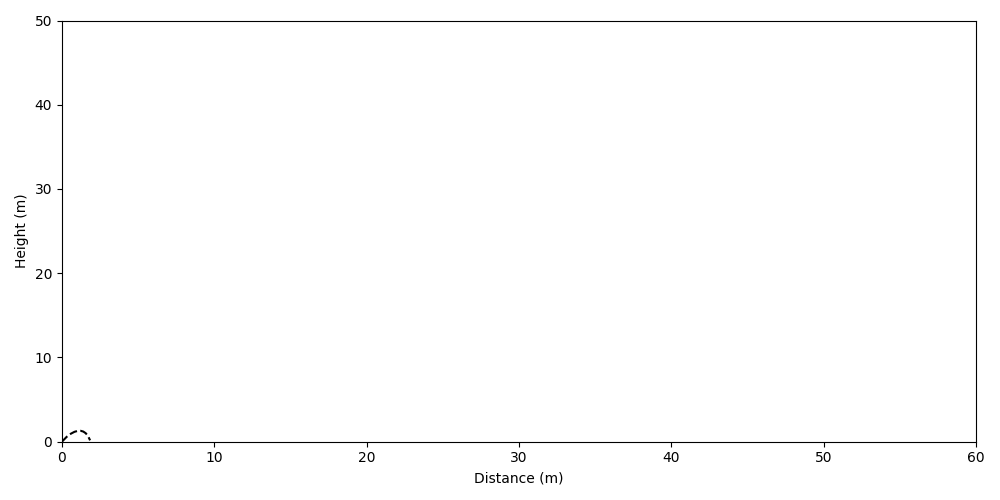

In [ ]:
# Answer to Problem 3

If we set the angle to 45, the initial velocity to 21, the mass to 1, the drag to .5, the area to .1, and the density to .1, we get landing at roughly x=40 though other combinations may also land at x=40.

----

## Incorporating more realistic data

The key challenge to truly calculating the trajectory of a projectile in reality is the variation in the parameters that were discussed above. Though the complexity of accurately calculating the density, area, and drag coefficient is considerable, we can take a first step by considering a few more realistic influences:
1. Density gradient
2. Inhomogeneous shape of the projectile
3. Wind

We will only consider point 2 for our dataset, but points 1 and 3 are explored in the [Appendix](#Appendix).

### Inhomogeneous projectile

The drag coefficient $c_d$ is mostly dependent on the material properties of the projectile and how easily the fluid can flow over it.
Imagine the object we are working with is trapezoidal (in 2D).
As such, it has very different drag coefficients depending on which side is facing in the direction of movement.

With this in mind, imagine we launch the projectile to constantly rotate.

In [ ]:
# Choose 4 drag coefficients between 0.1 (smooth sphere) and 1.28 (flat plat perpendicular to flow)
drags = [0.5, 0.7, 0.8, 0.6]

# Choose 4 areas between 0.1 and 0.5 (m^2)
areas = [0.1, 0.2, 0.5, 0.3]

As an approximation, imagine that we change sides every 2 seconds.

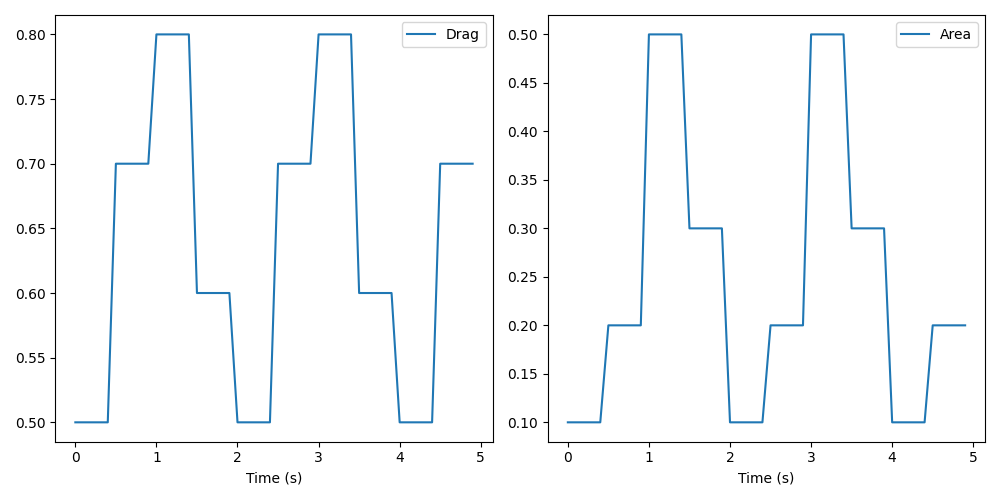

In [ ]:
switch_time = .5

def drag_func(t):
    drag_index = int((t // switch_time) % len(drags))
    return drags[drag_index]

def area_func(t):
    area_index = int((t // switch_time) % len(drags))
    return areas[area_index]

times = np.arange(0,5,.1)
drags_over_time = [drag_func(time) for time in times]
areas_over_time = [area_func(time) for time in times]

plt.close('all')
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(times,drags_over_time,label="Drag")
plt.xlabel("Time (s)")
plt.legend()

plt.subplot(122)
plt.plot(times,areas_over_time,label="Area")
plt.xlabel("Time (s)")
plt.legend()

plt.tight_layout()
plt.show()

Let's incorporate this into our simulation.
Since we don't have a function over time, we'll have to find the closest time point in our samples.

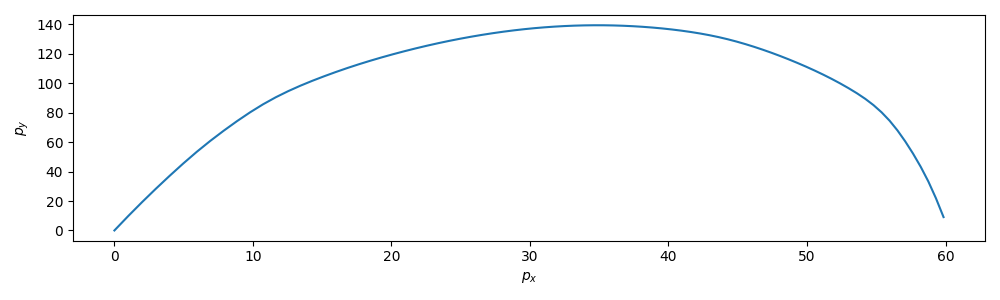

In [ ]:
def f_with_inhomogeneous_drag_and_area(t,u):
    c_d = -1*drag_func(t)
    A = area_func(t)
    return np.array(
        [
          0.5 * (rho*c_d*A) * u[0]**2 / m,
          g + 0.5 * (rho*c_d*A) * u[1]**2 / m,
          u[0],
          u[1]
        ]
   )

u_drag_solution = solve_ivp(f_with_inhomogeneous_drag_and_area, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

# Plot position
plt.close('all')
fig = plt.figure(figsize=(10,3))
plt.plot(u_drag_solution.y[2,:],u_drag_solution.y[3,:])
plt.xlabel("$p_x$")
plt.ylabel("$p_y$")

plt.tight_layout()
plt.show()

Imagine now that we are trying a variety of different objects with different sides and different drag coefficients on each side.

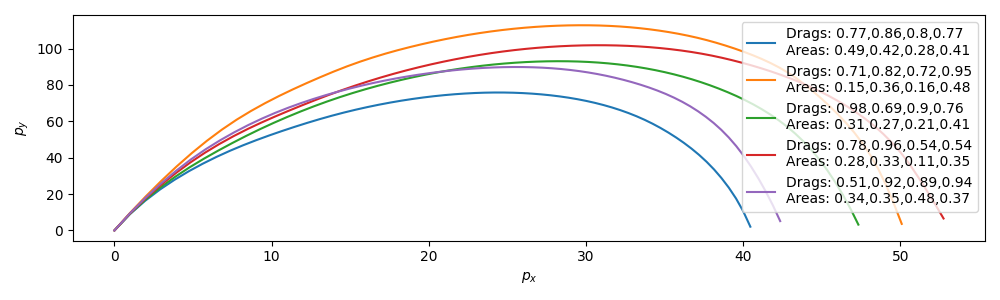

In [ ]:
# Choose 5 different objeccts with 4 drag coefficients between 0.5 (rough sphere) and 1 (standing adult)
np.random.seed(0) # This is so that we get the same result every time
all_drags = np.random.uniform(0.5, 1, size=(5,4))

# Choose 5 different objects with 4 areas between 0.1 and 0.5 (m^2)
all_areas = np.random.uniform(0.1, 0.5, size=(5,4))

plt.close('all')
fig = plt.figure(figsize=(10,3))
for drags,areas in zip(all_drags, all_areas):
    u_drag_solution = solve_ivp(f_with_inhomogeneous_drag_and_area, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

    # Plot position
    drags_label= ",".join(np.round(drags,2).astype(str))
    areas_label= ",".join(np.round(areas,2).astype(str))
    plt.plot(u_drag_solution.y[2,:],u_drag_solution.y[3,:],label="Drags: {}\nAreas: {}".format(drags_label,areas_label))
plt.xlabel("$p_x$")
plt.ylabel("$p_y$")
plt.legend()

plt.tight_layout()
plt.show()

## Generate a dataset for analysis

Let's consider a collection of different projectile launches that we have observed over time which incorporate the inhomogeneous drag.

We will consider 100 different launches (that actually landed).
In each, we will collect the:
1. Time
2. Distance and altitude (x,y position) of the projectile
3. Drag coefficient
4. Area of the projectile facing the direction of motion

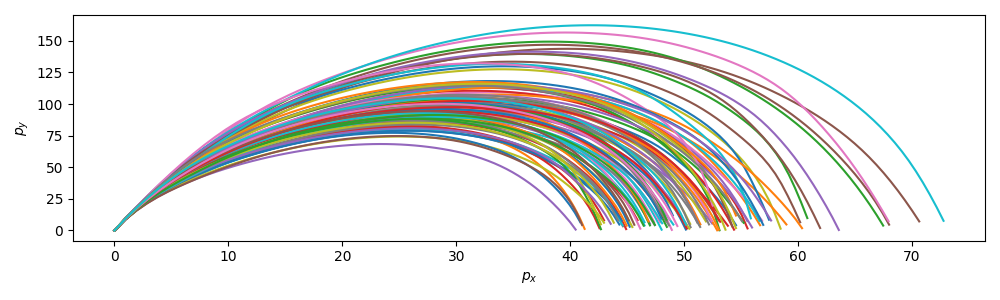

,Distance (m),Height (m),Drag coefficient,Projectile area (m^2)
Time (s),,,,
0.0,0.000000,0.000000,0.941653,0.230396
0.1,0.993547,9.355393,0.941653,0.230396
0.2,1.974224,17.601728,0.941653,0.230396
0.3,2.942283,24.951814,0.941653,0.230396
0.4,3.899622,31.602061,0.941653,0.230396
...,...,...,...,...
6.3,43.259990,32.493810,0.941653,0.230396
6.4,43.756220,26.760391,0.941653,0.230396
6.5,44.248037,20.192245,0.811836,0.443796


In [ ]:
np.random.seed(1)
num_launches = 100

all_drags = np.random.uniform(0.5, 1, size=(num_launches,4))
all_areas = np.random.uniform(0.1, 0.5, size=(num_launches,4))

plt.close('all')
fig = plt.figure(figsize=(10,3))
launches = []
for drags,areas in zip(all_drags,all_areas):

    u_drag_solution = solve_ivp(f_with_inhomogeneous_drag_and_area, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

    # Make sure the simulated launch actually hit the ground
    if u_drag_solution.status == 1:
      # Plot position
      plt.plot(u_drag_solution.y[2,:],u_drag_solution.y[3,:])

      # Make dataframe with information
      launch = dict()
      launch["Distance (m)"] = u_drag_solution.y[2,:]
      launch["Height (m)"] = u_drag_solution.y[3,:]
      launch["Drag coefficient"] = np.array([drag_func(u_drag_solution.t[i]) for i in range(len(u_drag_solution.t))])
      launch["Projectile area (m^2)"] = np.array([area_func(u_drag_solution.t[i]) for i in range(len(u_drag_solution.t))])
      launch = pd.DataFrame(launch, index=u_drag_solution.t)
      launch.index.name = "Time (s)"

      launches.append(launch)

plt.xlabel("$p_x$")
plt.ylabel("$p_y$")

plt.tight_layout()
plt.show()

# Show sample of one launch
launches[20]

Now, in reality each of these measurements would be polluted with some amount of noise due to errors in the measurement or some unaccounted for effect.
With this in mind, let's add some Gaussian noise to our measurements relative to their average.

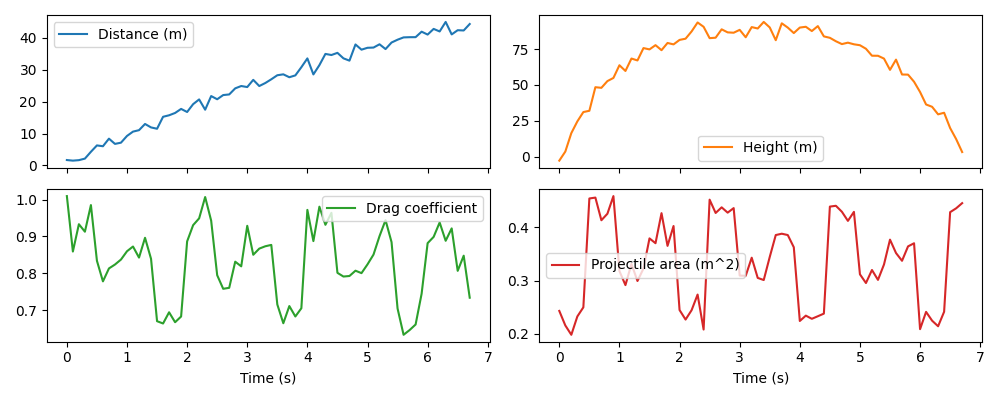

In [ ]:
# Add noise to data for each launch
for i in range(len(launches)):
    launch = launches[i]

    # Average variance for all columns
    averages = launch.abs().mean(axis=0).to_numpy()

    # Add Gaussian noise with std deviation 5% of average (except on time)
    launch = launch + .05*averages*np.random.normal(size=launch.shape)
    launches[i] = launch

# Plot one sample
launches[20].plot(subplots=True, layout=(2,2), figsize=(10,4))
plt.tight_layout()
plt.show()

In [ ]:
# Combine all launches into one pandas DataFrame
# (there will be duplicates in the "Times (s)" index column)
all_launches = pd.concat(launches)

# Save launch data
all_launches.to_csv("launches.csv")

## Appendix

There are more considerations that can influence the drag of the projectile.
See the following for some additional examples that you can add to your dataset if you'd like.

### Density gradient

Tthe density of air decreases at higher altitudes but is also influenced by temperature, pressure, and humidity.
Up to about 3000m, the density changes basically linearly.
There is a normal variation in density with altitude as shown below:

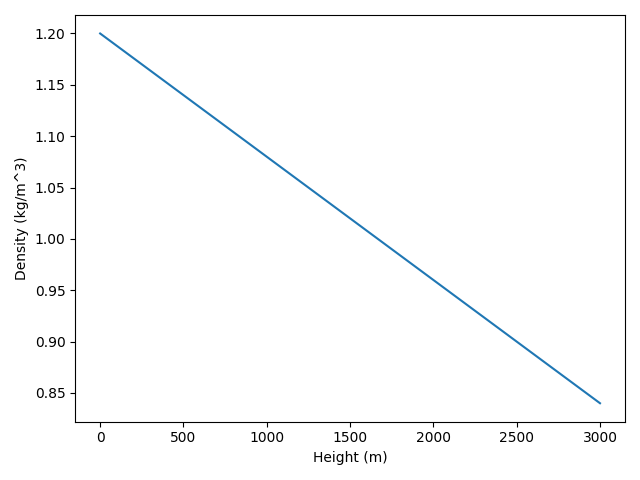

In [ ]:
plt.close('all')

# Consider heights from 0m to 3000m
heights = np.linspace(0, 3000)

# The normal slope of decrease in density is -0.1*1.2 per 1000m
slope = -0.1*1.2 / 1000

# We can make a function that returns the density as a function of height
density_func = lambda height: slope * height + 1.2

plt.plot(heights,density_func(heights))
plt.ylabel("Density (kg/m^3)")
plt.xlabel("Height (m)")
plt.tight_layout()
plt.show()

However, due to the variations noted above, there will be a slightly different density gradients in altitude with each launch of the projectile.
Let's generate some random density gradients by slightly changing the usual slope.

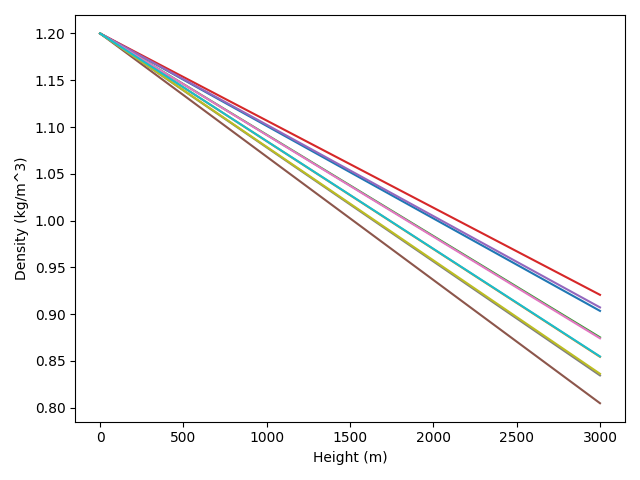

In [ ]:
# Make random slopes by perturbing the usual slope
# We'll use a normal distribution with mean 0 and standard deviation
# equal to 10% of the slope
np.random.seed(0)
slopes = slope + np.random.normal(0,.1*np.abs(slope),size=10)

plt.close('all')
for slope in slopes:
  plt.plot(heights,density_func(heights))

plt.ylabel("Density (kg/m^3)")
plt.xlabel("Height (m)")
plt.tight_layout()
plt.show()

These can have a small impact on the trajectory.

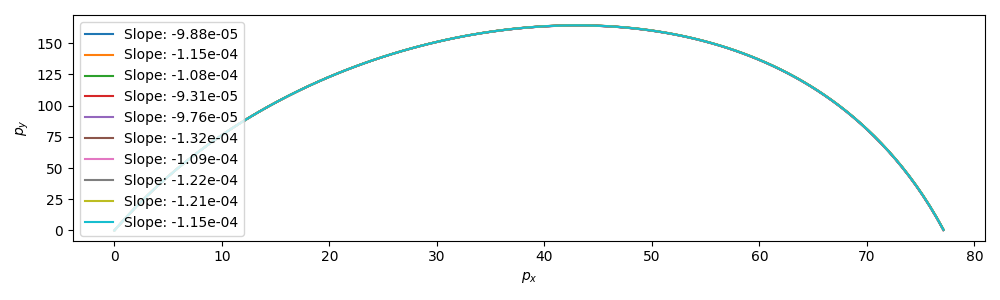

In [ ]:
def f_with_density_gradient(t,u):
    rho = density_func(u[1])
    return np.array(
        [
          0.5 * (rho*c_d*A) * u[0]**2 / m,
          g + 0.5 * (rho*c_d*A) * u[1]**2 / m,
          u[0],
          u[1]
        ]
   )

plt.close('all')
fig = plt.figure(figsize=(10,3))
for slope in slopes:
    u_drag_solution = solve_ivp(f_with_density_gradient, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

    # Plot position
    plt.plot(u_drag_solution.y[2,:],u_drag_solution.y[3,:],label="Slope: {:.2e}".format(slope))

plt.xlabel("$p_x$")
plt.ylabel("$p_y$")
plt.legend()

plt.tight_layout()
plt.show()

### Unsteady wind

One of the largest influences on the motion of our projectiles would be the wind which can vary at different heights and at different times.
Again, this is a very complex phenomenon, but we can try to simulate a simple varying wind.

Consider that our wind only influences the horizontal velocity of our projectile and that it slowly varies over time.
We can create a random polynomial to simulate this different wind velocity in Python using the `numpy.polynomial` module.

We will use "Chebyshev" polynomials because they have a domain on which they are reasonable values (rather that something like $x^2$ which gets very large as $x$ gets bigger).

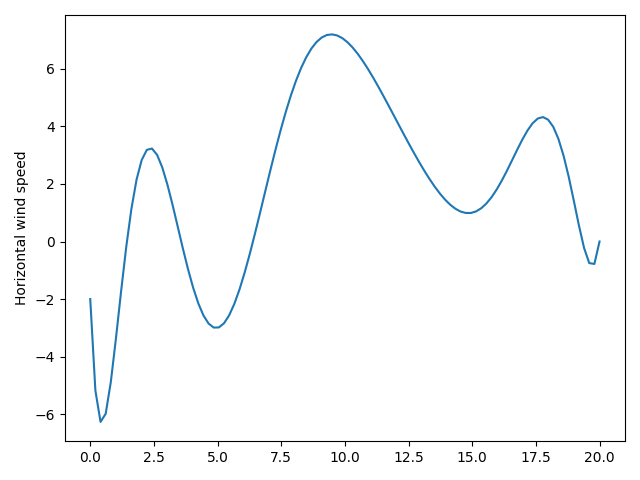

In [ ]:
# Create a random order 10 polynomial with random integer coefficients between -3 and 3 on the time domain 0 to 20
np.random.seed(0)
wind_coefficients = np.random.randint(-3,3,size=11)
wind_func = np.polynomial.Chebyshev(wind_coefficients, domain=[0,20])
wind_times = np.linspace(0,20,100)

plt.close('all')
plt.plot(wind_times,wind_func(wind_times))
plt.ylabel('Horizontal wind speed')
plt.tight_layout()
plt.show()

We can then incorporate this into our simulation by adding it to the horizontal velocity of our projectile relative to the fluid $v_x$.

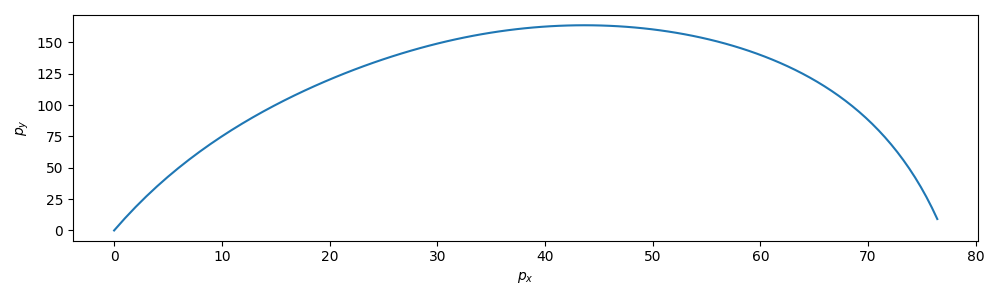

In [ ]:
def f_with_wind(t,u):
    wind_speed = wind_func(t)
    return np.array(
        [
          0.5 * (rho*c_d*A) * (u[0] + wind_speed)**2 / m,
          g + 0.5 * (rho*c_d*A) * u[1]**2 / m,
          u[0],
          u[1]
        ]
   )

u_wind_solution = solve_ivp(f_with_wind, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

# Plot position
plt.close('all')
fig = plt.figure(figsize=(10,3))
plt.plot(u_wind_solution.y[2,:],u_wind_solution.y[3,:],label="Slope: {}".format(slope))
plt.xlabel("$p_x$")
plt.ylabel("$p_y$")

plt.tight_layout()
plt.show()

It may be intially difficult to see how the wind influenced the trajectory, so we will consider a range of different generated winds.

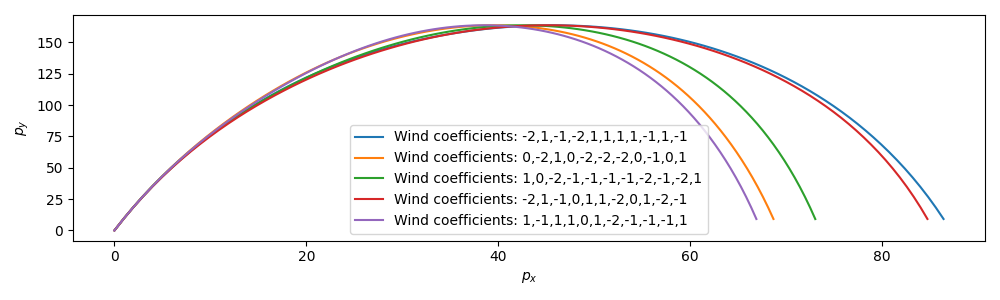

In [ ]:
# Create 5 random wind samples
np.random.seed(0)
all_wind_coefficients = np.random.randint(-2,2,size=(5,11))

plt.close('all')
fig = plt.figure(figsize=(10,3))
for wind_coefficients in all_wind_coefficients:
    wind_func = np.polynomial.Chebyshev(wind_coefficients, domain=[0,20])

    u_wind_solution = solve_ivp(f_with_wind, (t0,t1), u0, t_eval=np.arange(t0,t1,dt), events=hit_ground)

    # Plot position
    wind_label= ",".join(np.round(wind_coefficients,2).astype(str))
    plt.plot(u_wind_solution.y[2,:],u_wind_solution.y[3,:],label="Wind coefficients: {}".format(wind_label))
plt.xlabel("$p_x$")
plt.ylabel("$p_y$")
plt.legend()

plt.tight_layout()
plt.show()